# Audio declipping 

Diego Torres

In this notebook I will discuss and implement the paper "_Audio Declipping with Social Sparsity_", in which the authors present a novel technique to recover an audio signal that has been clipped to a maximum absolute value. The paper can be found online at https://hal.archives-ouvertes.fr/hal-01002998/document

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read
from scipy.signal import stft, istft
from scipy.sparse import csr_matrix

I start by reading the audio signal to use, which is a small extract of music that resembles the Star Wars theme

In [2]:
sr, music = read('music.wav')

I define the $\Phi$ and $\Phi^\star$ operators defined in the paper. They are the iSTFT and STFT (Short-Time Fourier Transform) respectively. They will allow us to go from the original signal space to the time-frequency domain. In the paper they refer to $\Phi$ as the dictionary of which you select a few coefficients to build the signal. The fact that we can reconstruct the signal with a reduced set of non-zero coefficients is crucial for the algorithm to work.

In [16]:
def PhiS(signal):
    _, _, z = stft(signal, fs=sr, nperseg=1024, noverlap=512)
    return z

In [17]:
def Phi(alpha):
    _, rec_signal = istft(alpha, fs=sr, nperseg=1024, noverlap=512)
    return rec_signal

In [ ]:
def plot_stft(f, t, z, title=None, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
    ax.imshow(z, aspect='auto', origin='lower', **kwargs)
    ax.set_xticks(np.arange(len(t))[::30], t[::30])
    ax.set_yticks(np.arange(len(f))[::30], f[::30])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    if ax is None:
        plt.show()

I extend the original signal with zeros so that applying $\Phi\Phi^\star$ gives something that is of the same length. Otherwise, $\Phi\Phi^\star$ will add aditional time stamps to the signal, and the algorithm will complain about shapes not matching. 

In [19]:
ext_music = np.concatenate((music, np.zeros(len(Phi(PhiS(music))) - len(music))))

I clip the signal to values between -20k and 20k, as shown in the following plot

In [20]:
clipped_music = np.clip(ext_music, -20000, 20000)

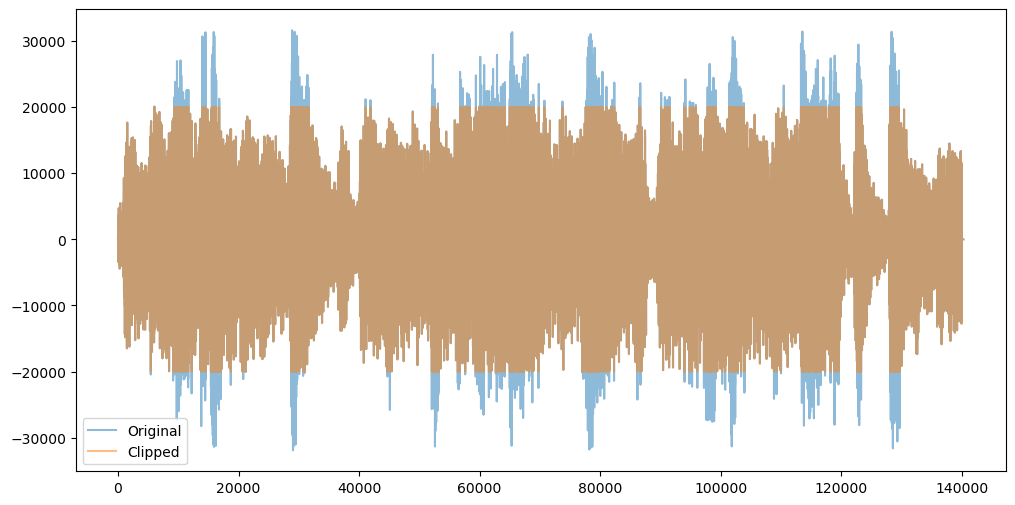

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(ext_music, label='Original', alpha=0.5)
plt.plot(clipped_music, label='Clipped', alpha=0.5)

plt.legend()
plt.show()

## Proposed algorithm

In a general setting of inverse problem, one tries to find a sparse representation of the signal such that the error is minimized. This is done by minimizing the mean square error of the reconstruction with the l1 norm of the coefficients (to guarantee sparsity). For the declipping problem, the optimization problem is 

$$
\hat{\alpha} = \arg \min_{\alpha} \|\alpha\|_0 \quad \text{s.t.} \quad \|y^r - M^r \Phi \alpha\|_2^2 \leq \epsilon.
$$

In this equation, $\alpha$ is the sparse representation of the signal, $y_r$ are the good (reliable) samples, and $M^r$ is the matrix that selects such good samples from the whole signal.

The main distinctive feature of declipping with respect to general inverse problems is that we already know a lower (or upper) bound to the value of the original signal. This will introduce a constraint in the optimization to make sure that in the areas of clipped audio, the absolute value of the solution is greater than or equal to the clipping value.

$$
\hat{\alpha} = \arg \min_{\alpha} \|\alpha\|_0 \quad \text{s.t.} \quad \|y^r - M^r \Phi \alpha\|_2^2 \leq \epsilon \quad \text{and} \quad |M^c \Phi \alpha| \geq |\theta_{\text{clip}}|
$$

Then, we want to relax this optimization problem, removing the constraint so that it's easier to solve. The authors introduce an operator based on the square hinge function, denoted as $[.]^2_+$, which, if applied to $\theta_\text{clip} - x$, penalizes $x$ if its absolute value is smaller than the know clipping value, and in that case the penalization is squared. Using this operator, the optimization problem becomes:

$$
\arg \min_{\alpha} \,\, \frac{1}{2} \|y^r - M^r \Phi \alpha\|_2^2 + \frac{1}{2} [\theta_{\text{clip}} - M^c \Phi \alpha]_2^+ + \lambda \|\alpha\|_1.
$$

In order to optimize this function, the authors suggest an ISTA based framework with special functions for the shrinking phase. They propose the Empirical Wiener (EW) operator and the persistent EW (PEW). The latter one makes sense because in the context of music or speech, the changes in frequencies can be smooth compared to sudden peaks in some frequencies when noise is present.

$$
\text{EW}: \tilde{\alpha}_{tf} = S^{EW}_{\lambda}(\alpha_{tf}) = \alpha_{tf} \left(1 - \frac{\lambda^2}{|\alpha_{tf}|^2} \right)_+
$$

$$
\text{PEW}: \tilde{\alpha}_{tf} = S^{PEW}_{\lambda}(\alpha_{tf}) = \alpha_{tf} \left(1 - \frac{\lambda^2}{\sum_{t' \in N(t)} |\alpha_{t'f}|^2} \right)_+
$$

Using either of this operators, the proposed algorithm is

$$
\begin{align*}
\textbf{Algorithm 1:}& \text{ Relaxed version of ISTA} \\
\text{Initialization:}& \quad \alpha^{(0)} \in \mathbb{C}^N, \quad z_0 = \alpha^{(0)}, \quad k = 1, \quad \delta = \|\Phi\Phi^\star\| \\
\text{Repeat:}& \\
&\quad g_1 = -\Phi^* M_r^T (y_r - M_r \Phi z^{(k-1)}); \\
&\quad g_2 = -\Phi^* M_c^T [\theta_{\text{clip}} - M_c \Phi z^{(k-1)}]_+; \\
&\quad \alpha^{(k)} = S_{\lambda/\delta}\left( z^{(k-1)} - \frac{1}{\delta} (g_1 + g_2) \right); \\
&\quad z^{(k)} = \alpha^{(k)} + \gamma (\alpha^{(k)} - \alpha^{(k-1)}); \\
&\quad k = k + 1; \\
&\text{Until convergence;}
\end{align*}

$$

As in similar algorithms, the authors recommend starting with a big value for $\lambda$ and decreasing it after a certain number of iterations.  

In my implementation, I start by defining the EW shrinking operator

In [22]:
def S_ew(x, T):
    return x*np.maximum((1 - (T**2)/np.abs(x)**2), 0)

As for the PEW operator, it's not as trivial to implement with NumPy, so I had to use regular Python for loops. I used the Numba library to try to speed up the code. 

In [23]:
@numba.jit(nopython=True)
def S_pew(alpha, T, neigh_window):
    # Initialize the output array
    alpha_tilde = np.zeros_like(alpha)

    # Determine the size of the time-frequency representation
    time_size, freq_size = alpha.shape

    # Apply the PEW operator to each coefficient
    for t in range(time_size):
        for f in range(freq_size):
            # Determine the neighborhood indices for time
            neigh_start = max(0, t - neigh_window // 2)
            neigh_end = min(time_size, t + neigh_window // 2 + 1)

            # Sum of squares of coefficients in the neighborhood
            neigh_sum = np.sum(np.abs(alpha[neigh_start:neigh_end, f])**2)

            # Apply the PEW operator (with positive part operation)
            alpha_tilde[t, f] = alpha[t, f] * max(1 - T**2 / neigh_sum, 0)

    return alpha_tilde

This is the main class responsible for performing the optimization. The values of $\delta$ and $\gamma$ are fixed to 1 and 0.9 as suggested in the paper. I use row-wise representation of sparse matrices for $M_c$ and $M_r$, this allows to drastically reduce memory usage and keep the algorithm fast. The shrinkage method is a parameter of the declipping method so that it can be changed without having to recompute the initial variables again. Here I don't use the shrinkage method for $\lambda$ proposed, but rather decrease it after every iteration. 

In [47]:
class Declipper:
    
    delta = 1
    gamma = 0.9

    def __init__(self, audio, clipped_audio, clipping_value) -> None:
        self.audio = audio
        self.clipped_audio = clipped_audio

        self.bad_idx = np.where(np.abs(clipped_audio) == clipping_value)[0]
        self.good_idx = np.where(np.abs(clipped_audio) != clipping_value)[0]

        self.M_c = self.give_matrix(self.bad_idx, len(audio))
        self.M_r = self.give_matrix(self.good_idx, len(audio))

        self.y_r = clipped_audio[self.good_idx]
        self.theta_clip = clipped_audio[self.bad_idx]
        self.alpha = None

    def declip_sound(self, shrinkage_method, max_iter, *, lamb_range, **kwargs):
        alpha = PhiS(self.clipped_audio)
        alpha_old = alpha.copy()
        z = alpha.copy()
        lambda_list = np.geomspace(*lamb_range, max_iter)

        snrs = []
        for i, lamda in enumerate(lambda_list):
            g_1 = -PhiS(self.M_r.T.asformat('csr')@(self.y_r-self.M_r@(Phi(z))))
            g_2 = -PhiS(self.M_c.T.asformat('csr')@np.where(np.abs(self.M_c@(Phi(z)))
                        > np.abs(self.theta_clip), 0, (self.theta_clip-self.M_c@(Phi(z)))))

            alpha = shrinkage_method(z - 1/self.delta * (g_1 + g_2), lamda/self.delta, **kwargs)
            z = alpha + self.gamma*(alpha-alpha_old)

            snrs.append(self.SNR(alpha, self.audio))    

            if np.max(np.abs(alpha-alpha_old)) < 1e-6:
                print('Converged at iteration', i+1)
                break

            alpha_old = alpha.copy()

        self.alpha = alpha

        return snrs
    
    def SNR(self, alpha, true_signal):
        rec = Phi(alpha)
        return 20*np.log10(np.linalg.norm(self.M_c@rec)/np.linalg.norm(self.M_c@(true_signal-rec)))

    @staticmethod
    def give_matrix(idx, length):
        return csr_matrix((np.ones(len(idx)), (np.arange(len(idx)), idx)), shape=(len(idx), length))

## Use on the music signal

In [48]:
declipper = Declipper(ext_music, clipped_music, 20000)

In [50]:
snr_values = declipper.declip_sound(S_ew, 1000, lamb_range=(10, 0.01))

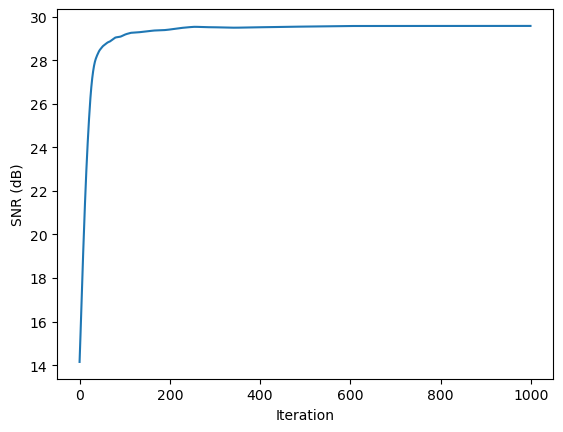

In [51]:
plt.plot(snr_values)
plt.xlabel('Iteration')
plt.ylabel('SNR (dB)')
plt.show()

In [52]:
f, t, z = stft(ext_music, fs=sr, nperseg=1024, noverlap=512)

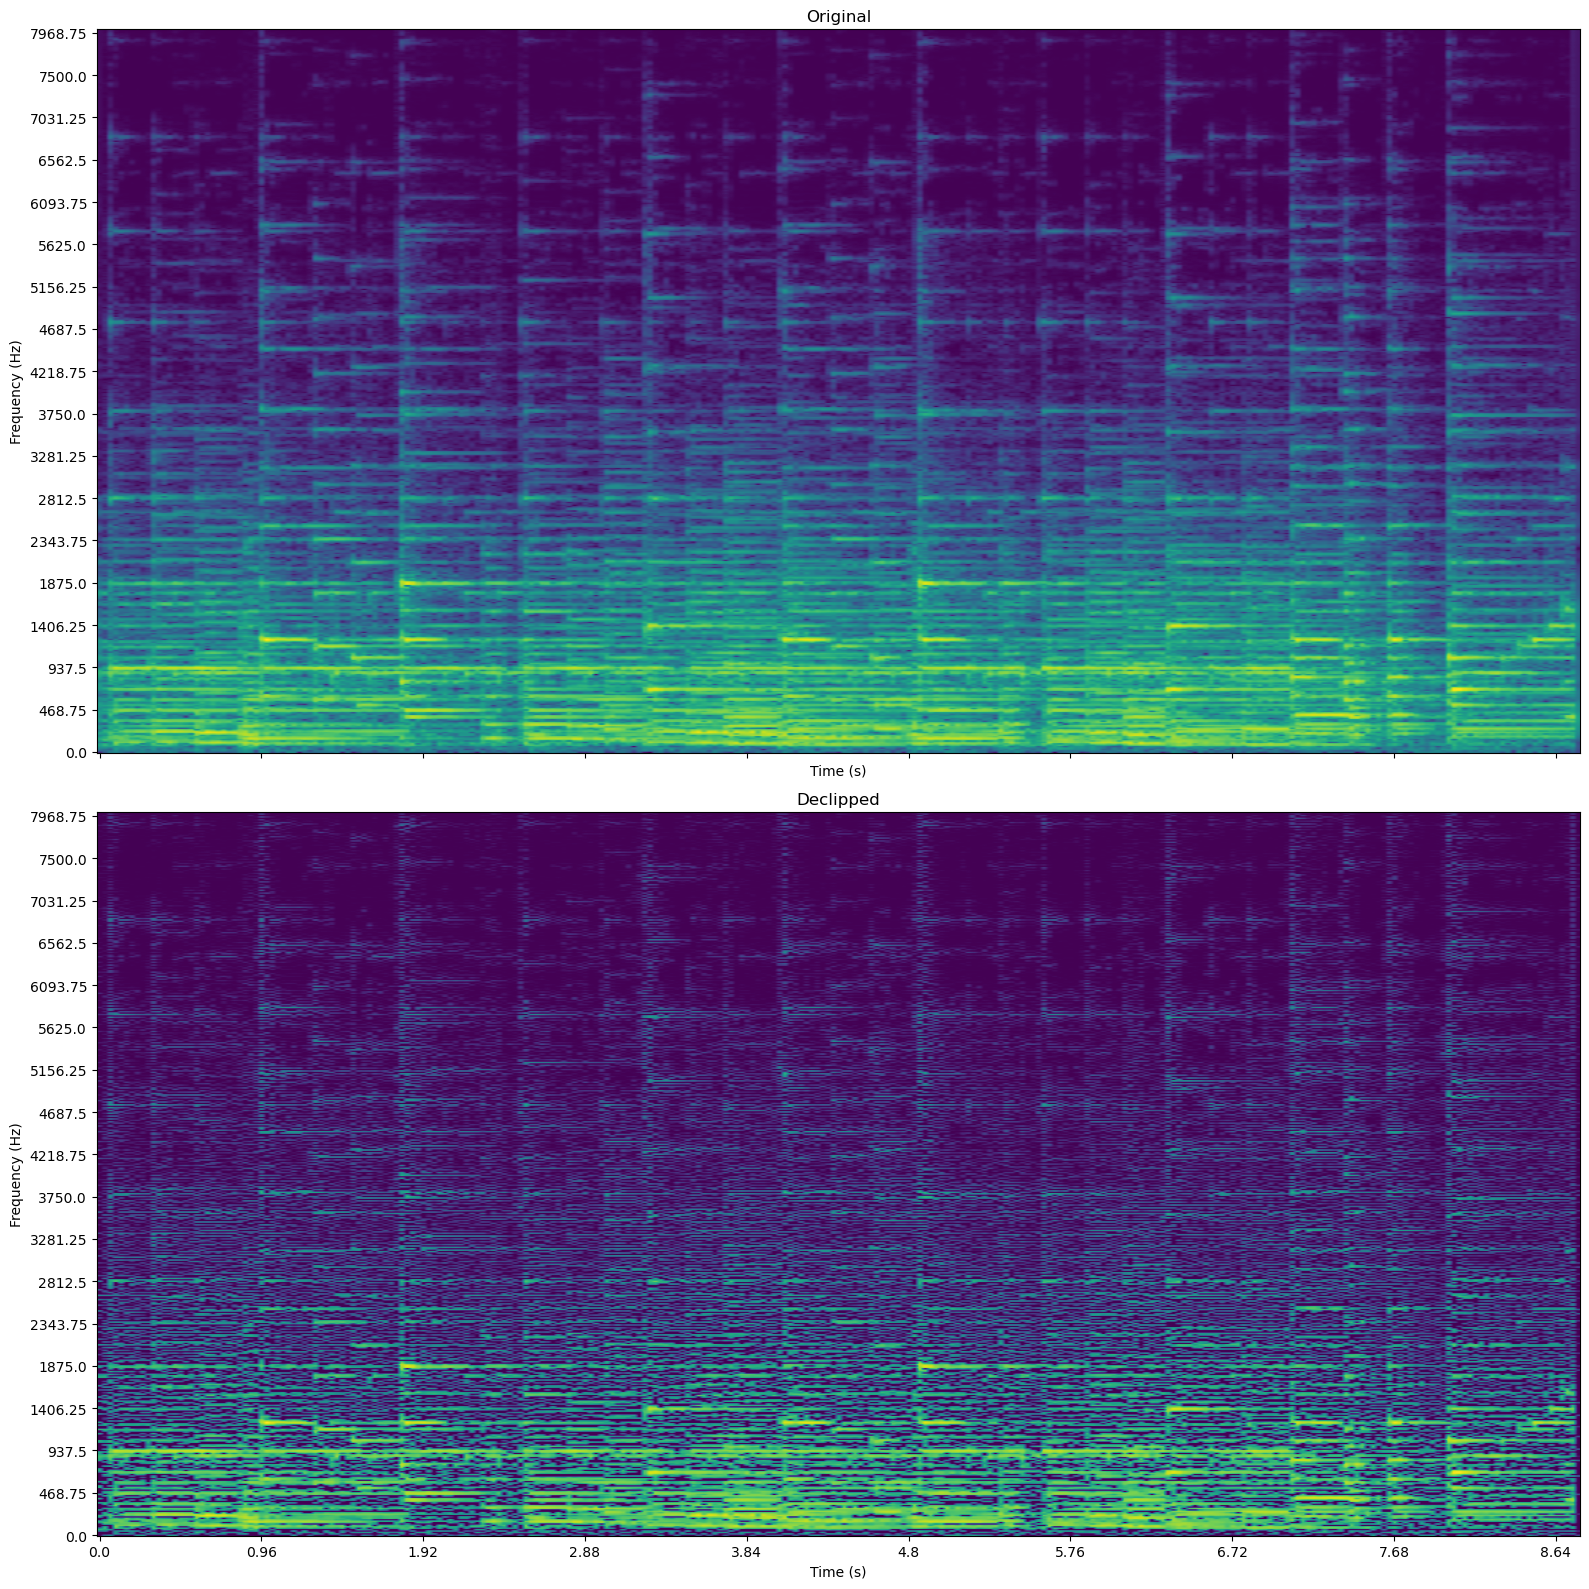

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), sharex=True, sharey=True)

plot_stft(f, t, np.log(np.abs(z)+1), title='Original', ax=ax1)

plot_stft(f, t, np.log(np.abs(declipper.alpha)+1), title='Declipped', ax=ax2)

plt.tight_layout()
plt.show()

In [54]:
declipped = Phi(declipper.alpha)

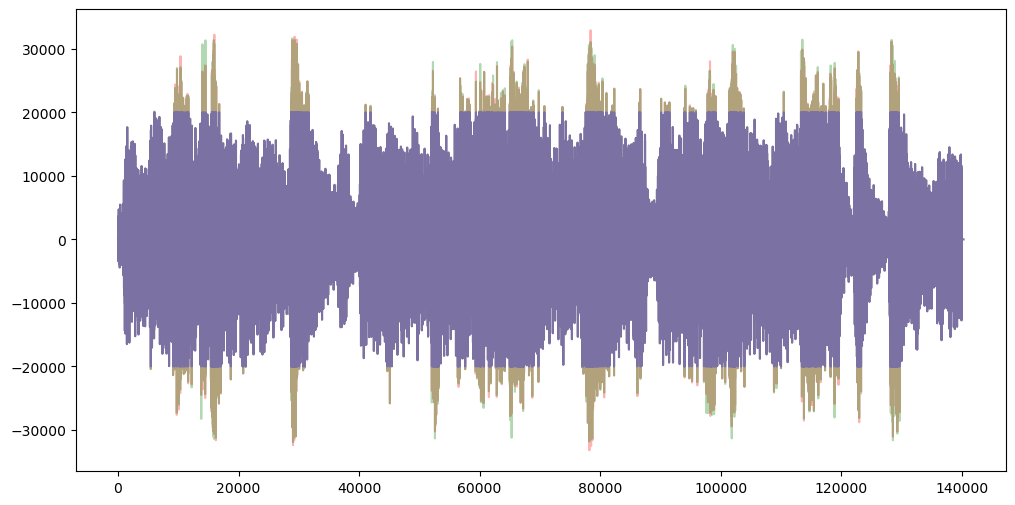

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(declipped, c='red', alpha=0.3)
plt.plot(ext_music, c='green', alpha=0.3)
plt.plot(clipped_music, c='blue', alpha=0.3)
plt.show()

We can see that the algorithm works very well, with a SNR going from 14 to almost 30, and reaching a plateau very early in the loop even if convergence in $\alpha$ is not achieved. 

### Using the PEW

In [56]:
snr_values = declipper.declip_sound(S_pew, 1000, lamb_range=(10, 0.01), neigh_window=7)

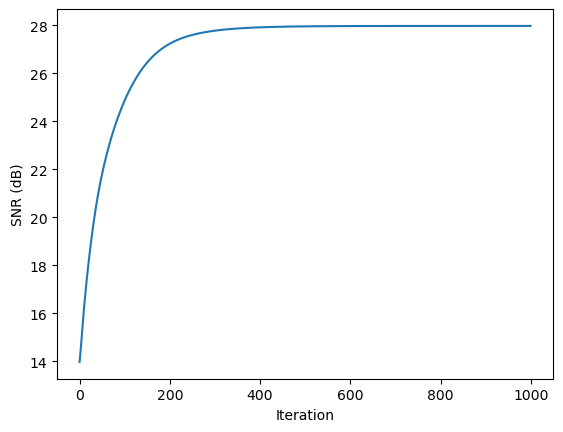

In [58]:
plt.plot(snr_values)
plt.xlabel('Iteration')
plt.ylabel('SNR (dB)')
plt.show()

In [59]:
declipped = Phi(declipper.alpha)

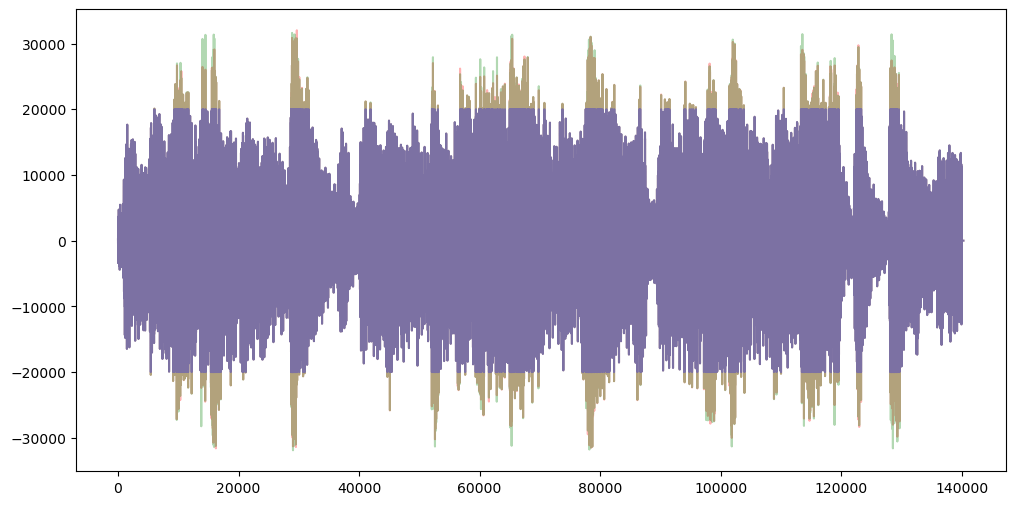

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(declipped, c='red', alpha=0.3)
plt.plot(ext_music, c='green', alpha=0.3)
plt.plot(clipped_music, c='blue', alpha=0.3)
plt.show()

Using PEW didn't improve the results, at least with the same values for the hyperparameters and a neighboring window of 7. The only apparent advantage is that the SNR curve seems smoother than before.

## Exploration of hyper parameters

In [61]:
lambda_starters = [1, 5, 10, 20, 100]
lambda_enders = [0.1, 0.001, 0.0001, 0.00001]

results = {}
for starter in lambda_starters:
    for ender in lambda_enders:
        snr_values = declipper.declip_sound(S_ew, 1000, lamb_range=(starter, ender))
        results[(starter, ender)] = snr_values

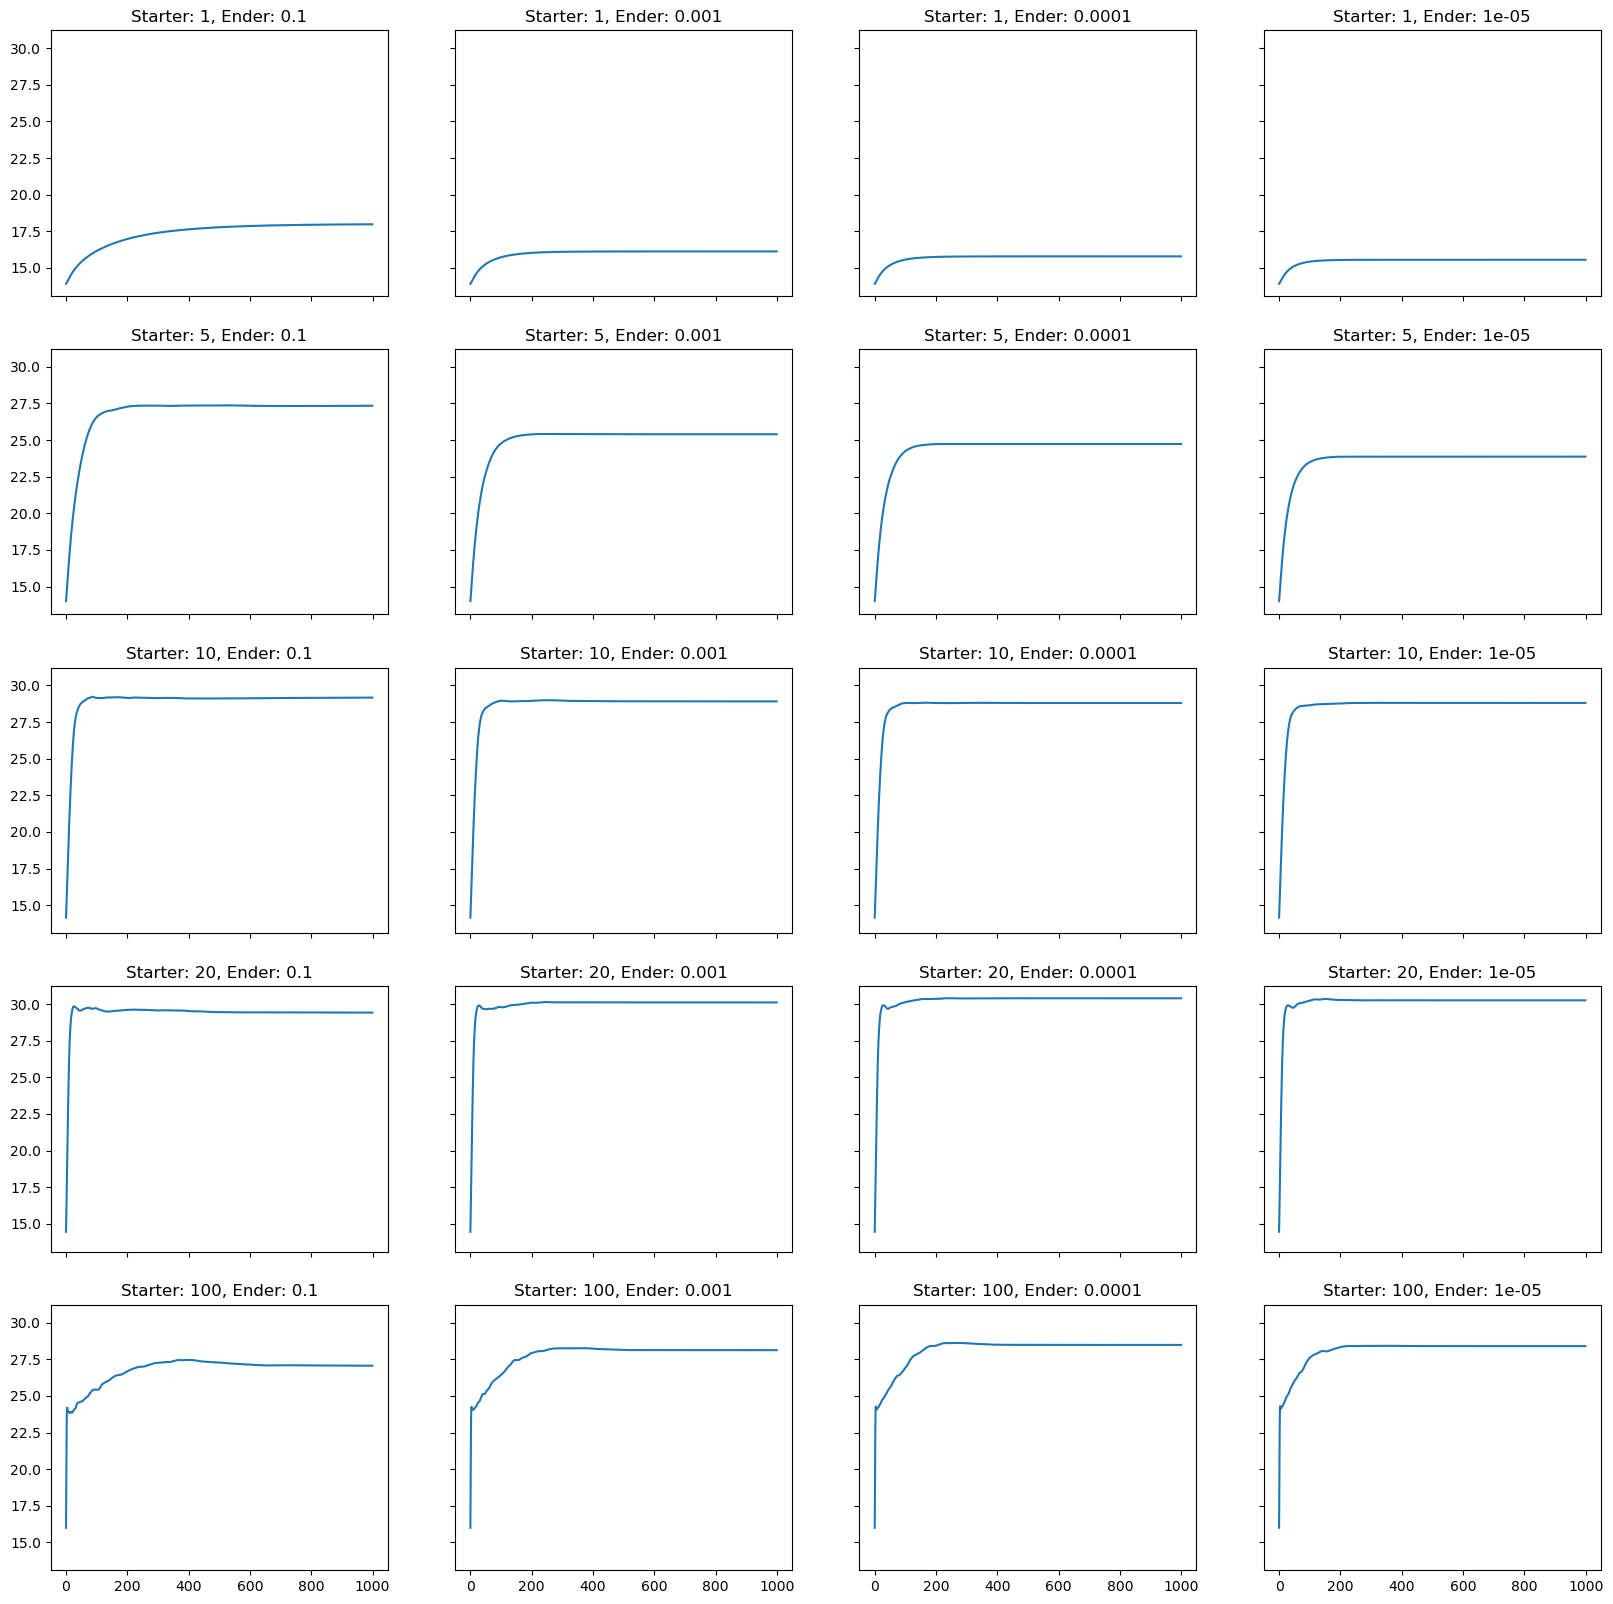

In [63]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex=True, sharey=True)

for i, starter in enumerate(lambda_starters):
    for j, ender in enumerate(lambda_enders):
        axes[i, j].plot(results[(starter, ender)])
        axes[i, j].set_title(f'Starter: {starter}, Ender: {ender}')

In [64]:
max((np.max(results[(starter, ender)]), starter, ender) for starter in lambda_starters for ender in lambda_enders)

(30.39992092090372, 20, 0.0001)

We can see that the highest SNR was achieved by starting with $\lambda=20$ and decreasing it until 0.0001.  